In [ ]:
import pandas as pd
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels
import tensorflow as tf
from datetime import timedelta, date, datetime
import warnings
from sklearn.preprocessing import normalize

# define functions


## plot series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## windowed dataset

In [ ]:
def windowed_dataset(series, window_size, forcaste_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forcaste_size, shift=forcaste_size, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forcaste_size))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-forcaste_size], window[-forcaste_size:]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

## model forecast

In [ ]:
def model_forecast(model, series, forcaste_size, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=forcaste_size, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

## plot loss

In [ ]:
def plot_loss(epoches, train_loss, val_loss=None, start=0):
    if val_loss:
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

        # Plot the first data on the first subplot
        ax1.plot(range(start, epoches), train_loss[start:], 'b', label='Training Loss')

        # Plot the second data on the second subplot
        ax2.plot(range(start, epoches), val_loss[start:], 'b', label='validation Loss')

        # Customize the plots if needed
        ax1.set_title('Training Loss')
        ax1.set_xlabel('epoches')
        ax1.set_ylabel('error')
        ax1.legend()

        ax2.set_title('validation Loss')
        ax2.set_xlabel('epoches')
        ax2.set_ylabel('error')
        ax2.legend()

        # Adjust layout to prevent overlapping
        plt.tight_layout()

    else:
        # Plot all but the first n
        plt.plot(range(start, epoches), train_loss[start:], 'b', label='Training Loss')

    # Display the plots
    plt.show()

## normalize data

In [ ]:
def normalize_data(data, max=None, min=None):
    if max is None:
        max = np.max(data)
    if min is None:
        min = np.min(data)
    return (data - min) / (max - min), max, min

# download dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp /content/drive/MyDrive/ai_projects/kaggle.json ~/.kaggle

! chmod 600  ~/.kaggle/kaggle.json

! kaggle datasets download fivethirtyeight/uber-pickups-in-new-york-city

! unzip /content/uber-pickups-in-new-york-city.zip

 99% 108M/109M [00:01<00:00, 111MB/s]  
100% 109M/109M [00:01<00:00, 98.2MB/s]
Archive:  /content/uber-pickups-in-new-york-city.zip
  inflating: Uber-Jan-Feb-FOIL.csv   
  inflating: other-American_B01362.csv  
  inflating: other-Carmel_B00256.csv  
  inflating: other-Dial7_B00887.csv  
  inflating: other-Diplo_B01196.csv  
  inflating: other-FHV-services_jan-aug-2015.csv  
  inflating: other-Federal_02216.csv  
  inflating: other-Firstclass_B01536.csv  
  inflating: other-Highclass_B01717.csv  
  inflating: other-Lyft_B02510.csv   
  inflating: other-Prestige_B01338.csv  
  inflating: other-Skyline_B00111.csv  
  inflating: uber-raw-data-apr14.csv  
  inflating: uber-raw-data-aug14.csv  
  inflating: uber-raw-data-janjune-15.csv  
  inflating: uber-raw-data-jul14.csv  
  inflating: uber-raw-data-jun14.csv  
  inflating: uber-raw-data-may14.csv  
  inflating: uber-raw-data-sep14.csv  


## classify dataset

In [ ]:
! mkdir Uber_trip_data_from_2014

! mv uber-raw-data-apr14.csv uber-raw-data-aug14.csv uber-raw-data-jul14.csv uber-raw-data-jun14.csv uber-raw-data-may14.csv uber-raw-data-sep14.csv Uber_trip_data_from_2014

In [ ]:
! mkdir Uber_trip_data_from_2015

! mv uber-raw-data-janjune-15.csv Uber_trip_data_from_2015

In [ ]:
! mkdir Aggregate_Statistics

! mv other-FHV-services_jan-aug-2015.csv Uber-Jan-Feb-FOIL.csv Aggregate_Statistics

In [ ]:
! mkdir Non_Uber_FLV_trips

! mv other* Non_Uber_FLV_trips

# Exploratory data analysis

In [ ]:
# Step 1: Get a list of all CSV files in a directory
csv_files = glob.glob('/content/Uber_trip_data_from_2014/*.csv')

# Step 2: Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Step 3: Iterate through each CSV file and append its data to the combined DataFrame
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Append the DataFrame to the combined DataFrame
    combined_df = combined_df.append(df, ignore_index=True)

# Step 4: Optionally, reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)

<ipython-input-243-e98b2d3b86c5>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-243-e98b2d3b86c5>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-243-e98b2d3b86c5>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-243-e98b2d3b86c5>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-243-e98b2d3b86c5>:13: FutureWarning: The frame.append method is deprecate

In [ ]:
def convert_to_hour(x):
    date, time = x.split()
    m, d, y = date.split('/')
    h = time[:-6]
    if len(d) == 1:
        d = '0' + d
    if len(m) == 1:
        m = '0' + m
    if len(h) == 1:
        h = '0' + h
    return y + '/' + m + '/' + d + '/' + h

new_df = np.vectorize(convert_to_hour)(combined_df['Date/Time'].to_numpy())

In [ ]:
counts = np.unique(new_df, return_counts=True)

## removing outliers

In [ ]:
series = counts[1]
series, max, min = normalize_data(series)
time = np.arange(len(series), dtype="float32")

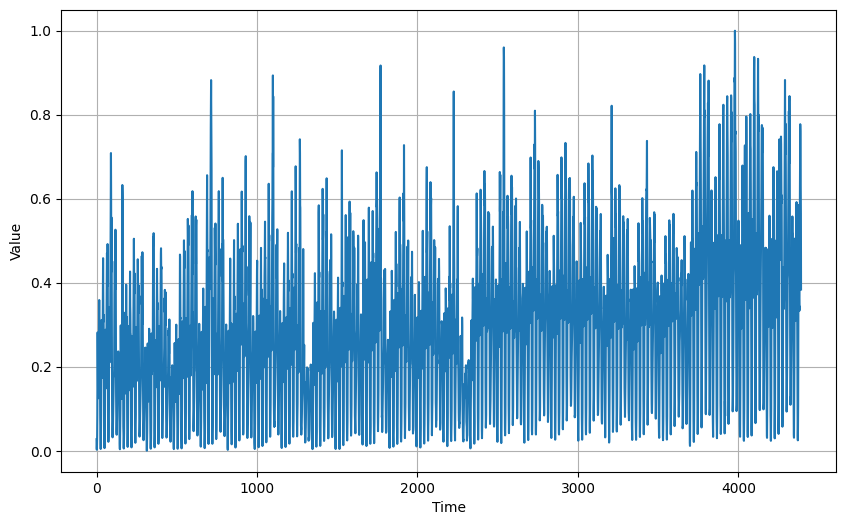

In [ ]:
# Plot the dataset
plot_series(time, series)

In [ ]:
mean = np.mean(series)

std = np.std(series)

z_scores = (series - mean) / std

(array([225., 355., 276., 239., 222., 282., 256., 263., 311., 287., 239.,
        246., 208., 165., 163., 162., 126.,  76.,  73.,  49.,  33.,  36.,
         23.,  25.,  20.,  10.,  10.,   6.,   3.,   2.]),
 array([-1.53088388, -1.35562594, -1.18036801, -1.00511007, -0.82985214,
        -0.6545942 , -0.47933627, -0.30407833, -0.1288204 ,  0.04643754,
         0.22169547,  0.39695341,  0.57221135,  0.74746928,  0.92272722,
         1.09798515,  1.27324309,  1.44850102,  1.62375896,  1.79901689,
         1.97427483,  2.14953277,  2.3247907 ,  2.50004864,  2.67530657,
         2.85056451,  3.02582244,  3.20108038,  3.37633831,  3.55159625,
         3.72685418]),
 <BarContainer object of 30 artists>)

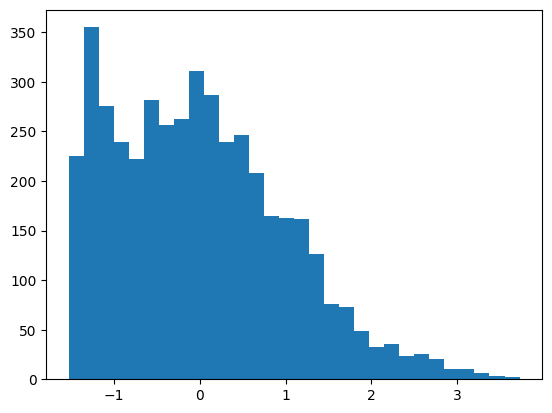

In [ ]:
plt.hist(z_scores, bins=30)

In [ ]:
threshold = 2.7

(np.sum(np.abs(z_scores) < threshold)/len(z_scores))*100

98.90685493053975

In [ ]:
nearest_positive = np.abs(np.where(z_scores < 0, 10, z_scores) - threshold).argmin()
nearest_negative = np.abs(np.abs(np.where(z_scores >= 0, 10, z_scores)) - threshold).argmin()

series = np.where(z_scores > threshold, series[nearest_positive], series)
series = np.where(z_scores < -1 * threshold, series[nearest_negative], series)

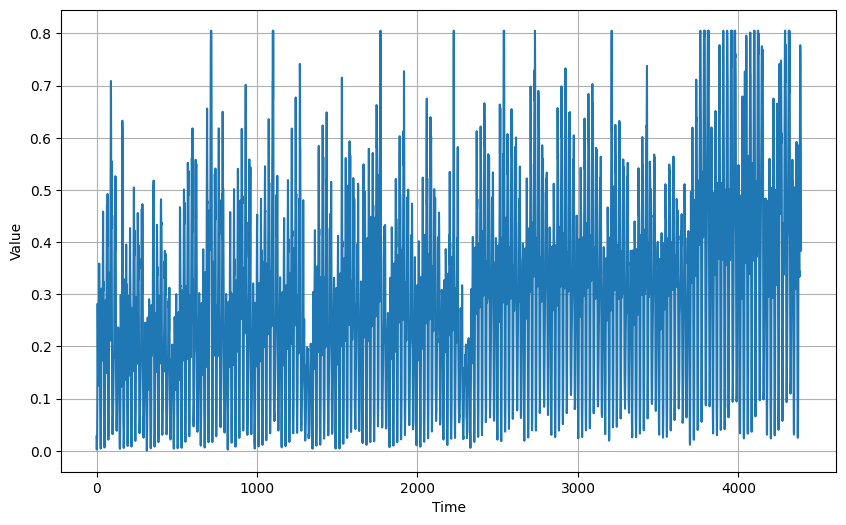

In [ ]:
# Plot the dataset without outliers
plot_series(time, series)

## plot the last 90 days

In [ ]:
days_90 = series[-90*24:]
days_90_time_steps = np.arange(len(days_90), dtype="float32")

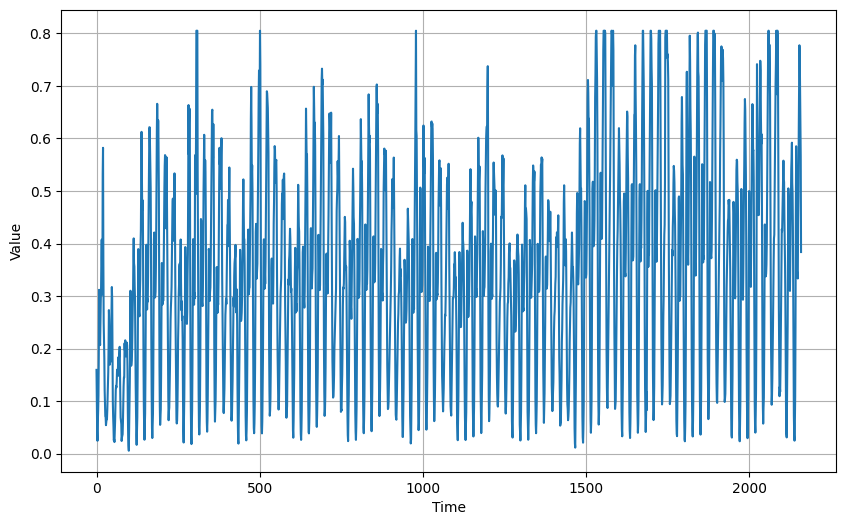

In [ ]:
plot_series(days_90_time_steps, days_90)

### stationarity of data for last 90 days

In [ ]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(days_90)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.00992322641561065  if above 0.05, data is not stationary


### seasonality and trend for last 90 days

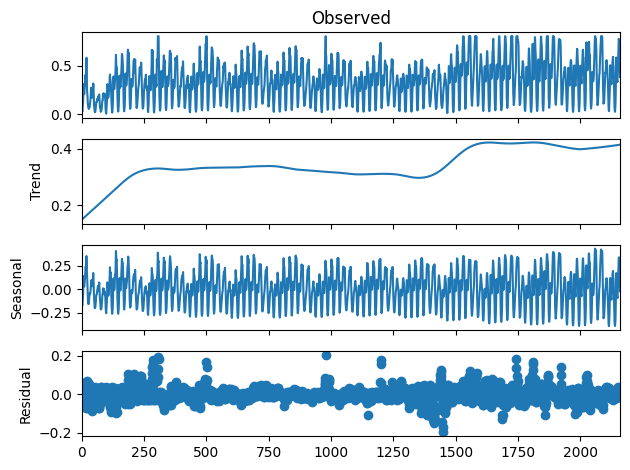

In [ ]:
from statsmodels.tsa.seasonal import STL

# Perform seasonal decomposition
result = STL(days_90, 7*24).fit()

# Plot the decomposition
result.plot()
plt.show()


### autocorrelation between data for last 90 days

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

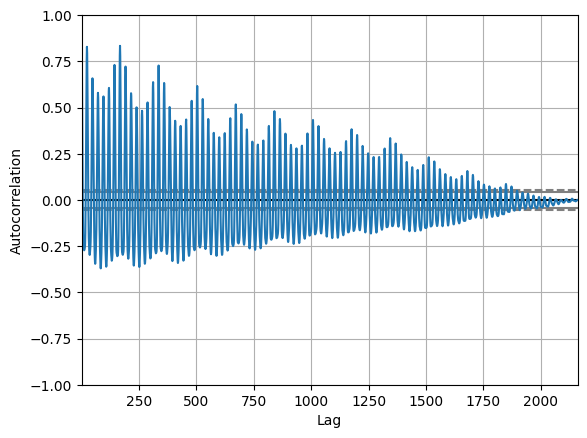

In [ ]:
#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(days_90)
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#  prepare tensorflow dataset and featurs (based on last 90 days)

## Split the Dataset

In [ ]:
# Define the split time
split_ration = 0.8
split_time = int(split_ration*len(days_90))

# Get the train set
time_train = days_90_time_steps[:split_time]
x_train = days_90[:split_time]

# Get the validation set
time_valid = days_90_time_steps[split_time:]
x_valid = days_90[split_time:]

### plot train and validation set

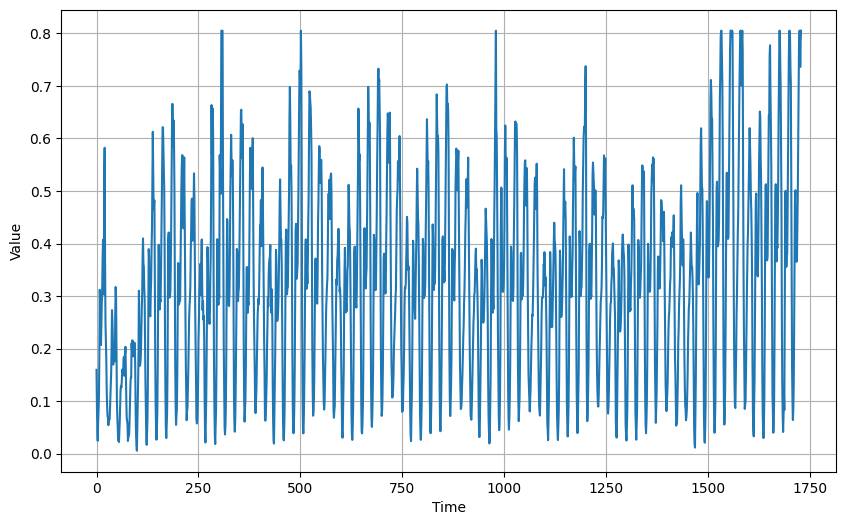

In [ ]:
# Plot the train dataset
plot_series(time_train, x_train)

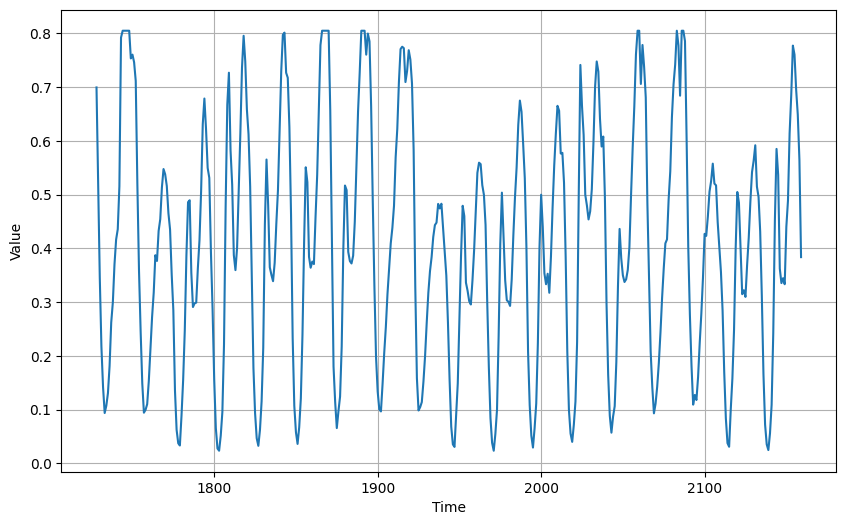

In [ ]:
# Plot the validation dataset
plot_series(time_valid, x_valid)

## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 7*24
forceast_size = 24
batch_size = 128
shuffle_buffer_size = 1000

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, forceast_size, batch_size, shuffle_buffer_size)
validation_dataset = windowed_dataset(x_valid, window_size, forceast_size, batch_size, shuffle_buffer_size)

# Build the LSTM Model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(window_size, input_shape=(window_size, 1), return_sequences=True),
  tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.00001)),
  tf.keras.layers.Dense(forceast_size)
])

# Print the model summary
print(model_lstm.summary())

# compile model with specified parameters
model_lstm.compile(
                  loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.5e-4)
                 )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 168)          114240    
                                                                 
 lstm_1 (LSTM)               (None, 64)                59648     
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
Total params: 175448 (685.34 KB)
Trainable params: 175448 (685.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Train the Model

In [ ]:
# Train the model
epoches = 300
history = model_lstm.fit(dataset,epochs=epoches, validation_data=validation_dataset)

Epoch 1/300
1/1 [==============================] - 10s 10s/step - loss: 0.0796 - val_loss: 0.1070
Epoch 2/300
1/1 [==============================] - 0s 365ms/step - loss: 0.0791 - val_loss: 0.1063
Epoch 3/300
1/1 [==============================] - 0s 388ms/step - loss: 0.0786 - val_loss: 0.1056
Epoch 4/300
1/1 [==============================] - 0s 328ms/step - loss: 0.0780 - val_loss: 0.1049
Epoch 5/300
1/1 [==============================] - 0s 273ms/step - loss: 0.0775 - val_loss: 0.1043
Epoch 6/300
1/1 [==============================] - 0s 204ms/step - loss: 0.0771 - val_loss: 0.1036
Epoch 7/300
1/1 [==============================] - 0s 184ms/step - loss: 0.0766 - val_loss: 0.1030
Epoch 8/300
1/1 [==============================] - 0s 176ms/step - loss: 0.0761 - val_loss: 0.1023
Epoch 9/300
1/1 [==============================] - 0s 177ms/step - loss: 0.0756 - val_loss: 0.1017
Epoch 10/300
1/1 [==============================] - 0s 168ms/step - loss: 0.0751 - val_loss: 0.1011
Epoch 11/3

### ploting the train and validation loss

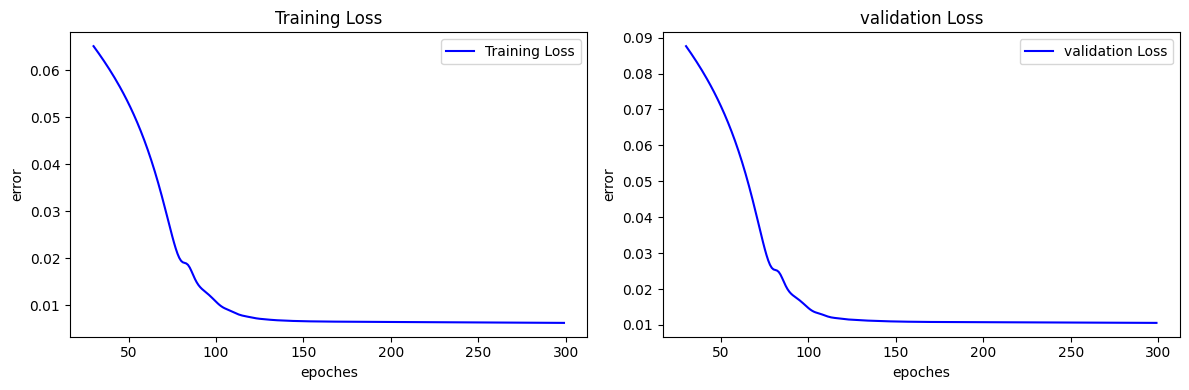

In [ ]:
plot_loss(epoches, history.history['loss'], history.history['val_loss'], start=30)

## Forecast

In [ ]:
# Use helper function to generate predictions
forecast = model_forecast(model_lstm, np.concatenate((days_90[split_time-window_size:split_time], x_valid)), forceast_size, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze().flatten()

1/1 [==============================] - 0s 33ms/step


In [ ]:
results = results[(len(results) - len(x_valid)):]

## Evaluation

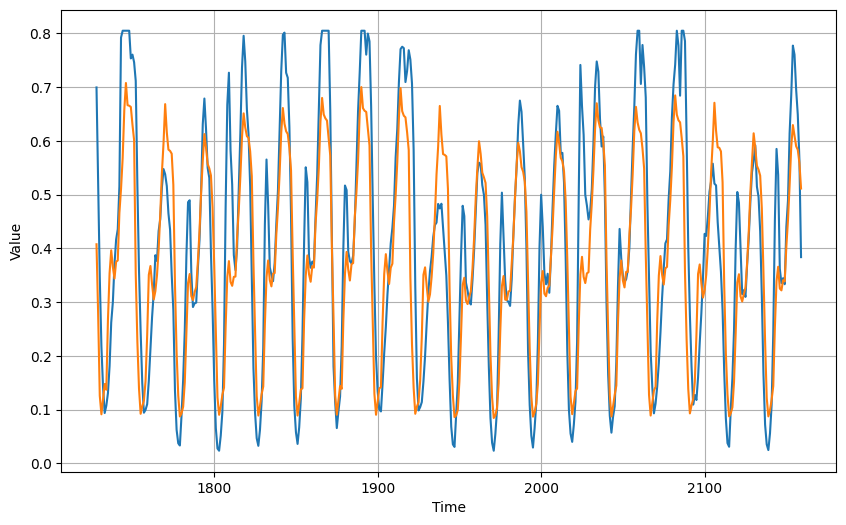

In [ ]:
# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the metrics
print('mse: ', tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print('mae: ', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

mse:  0.015839532
mae:  0.09558714
